In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
import scipy
from collections import Counter
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from matplotlib.patches import Rectangle
import importlib  
baseline = importlib.import_module("flickr-cropping-dataset.baselines.saliency_crop_accum")

# Multi-duration cropping 

1. Ensure that you have initialized submodules (`git submodule update --init`) 
2. [Download the codecharts data](http://multiduration-saliency.csail.mit.edu/data/codecharts_data.zip) and download or generate multiduration predictions. 
3. Adjust the data and prediction paths in the cell below
4. Run notebook to generate predictions

## TODO: fill in variables below

In [12]:
# location of the codecharts data
codecharts_images_path = os.path.join('..', 'codecharts_data','raw_img')
# location of the multi-duration saliency predictions
pred_path = os.path.join('..', 'mdsem_preds')
# number of results to produce
n_results = 10

## Setup

In [13]:
# constants
time_pts = [500, 3000, 5000]

# temporary folder for resizing heatmap images to match same size
tmp_folder = 'cropping_tmp'
if not os.path.exists(tmp_folder): 
    os.makedirs(tmp_folder)

# temporary heatmap file name
# for saliency crop 
tmp_heatmap_file = os.path.join(tmp_folder, "temporary.jpg")

In [14]:
# Gather file names

saliency_paths =  [os.path.join(pred_path,'{}'.format(time)) for time in time_pts]
sal_imnames = [os.listdir(saliency_path) for saliency_path in saliency_paths]
ori_imnames = os.listdir(codecharts_images_path)

get_filetype = lambda file: file.split('.')[-1]
ori_filetype = get_filetype(ori_imnames[0])
sal_filetype = get_filetype(sal_imnames[0][0])

shared_imname = set([imname.split('.')[0] for imname in ori_imnames])
for imnames in sal_imnames:
    shared_imname = shared_imname & set([imname.split('.')[0] for imname in imnames])

In [15]:
imnames = sorted(list(shared_imname))[:n_results]

## Produce predictions

CAT2000Actions_001


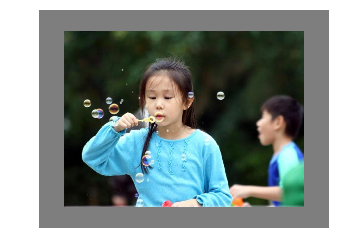

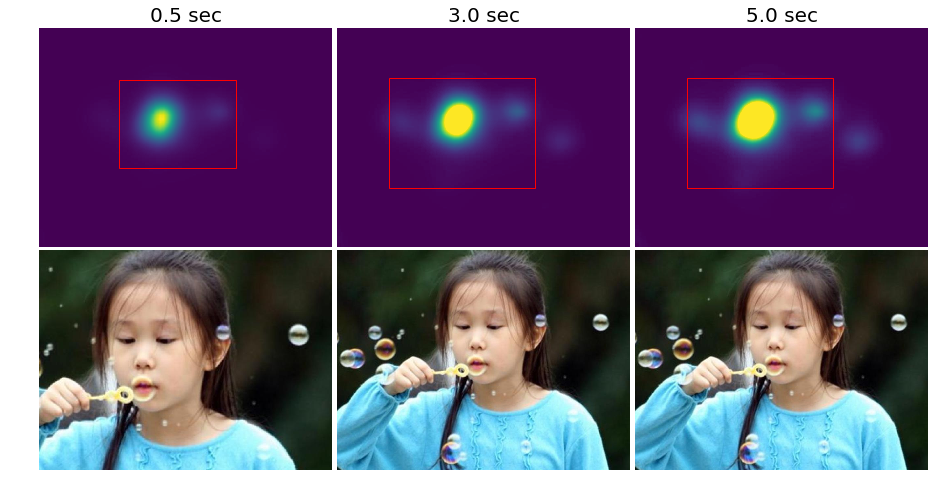

CAT2000Actions_003


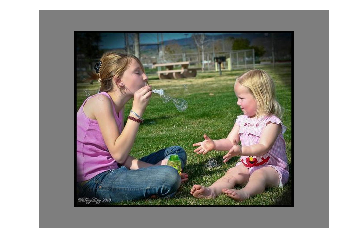

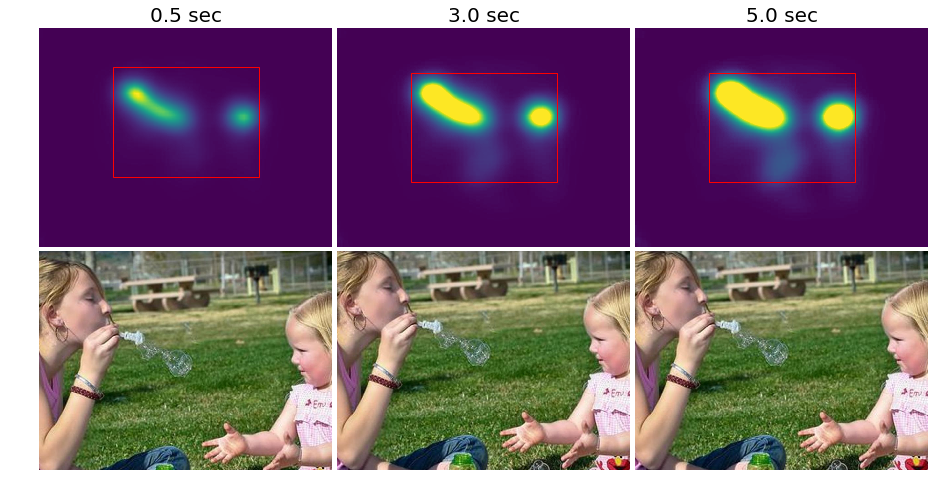

CAT2000Actions_005


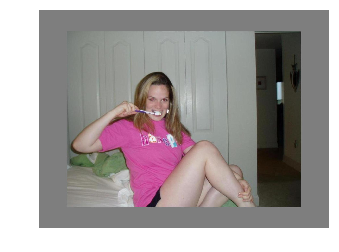

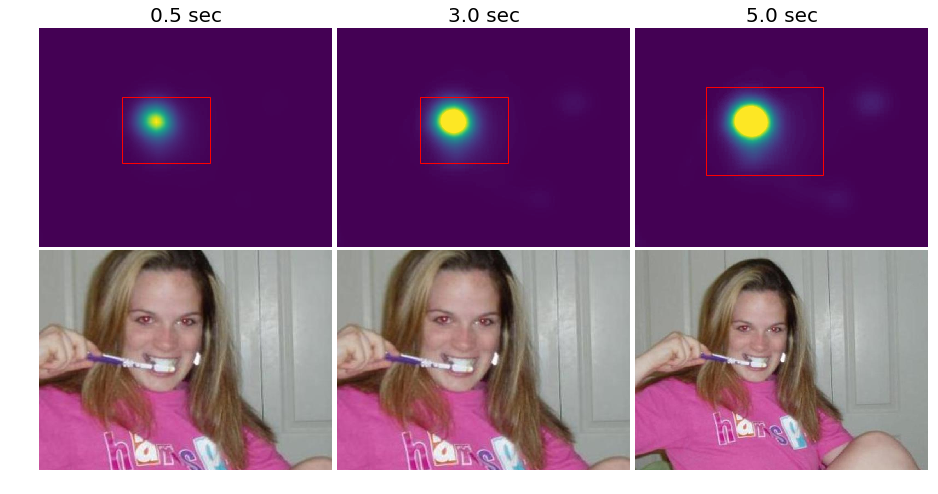

CAT2000Actions_007


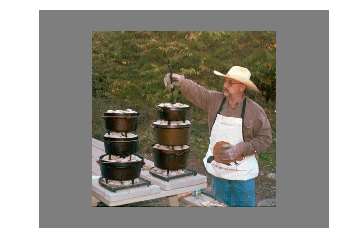

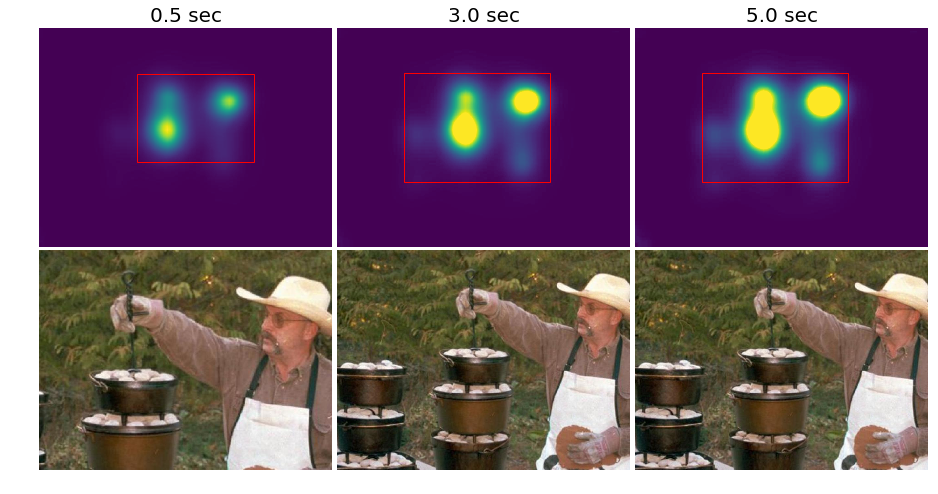

CAT2000Actions_009


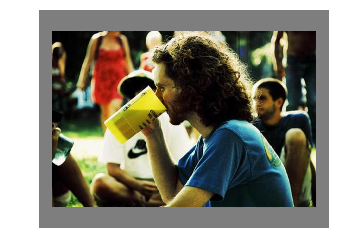

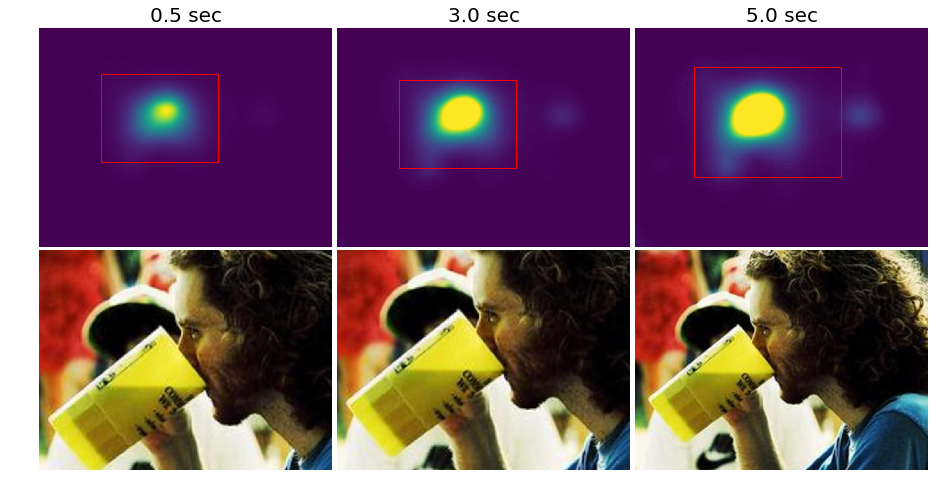

CAT2000Actions_011


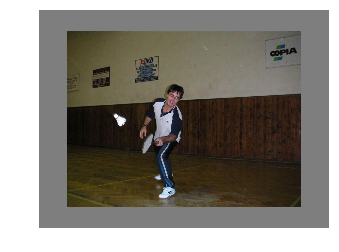

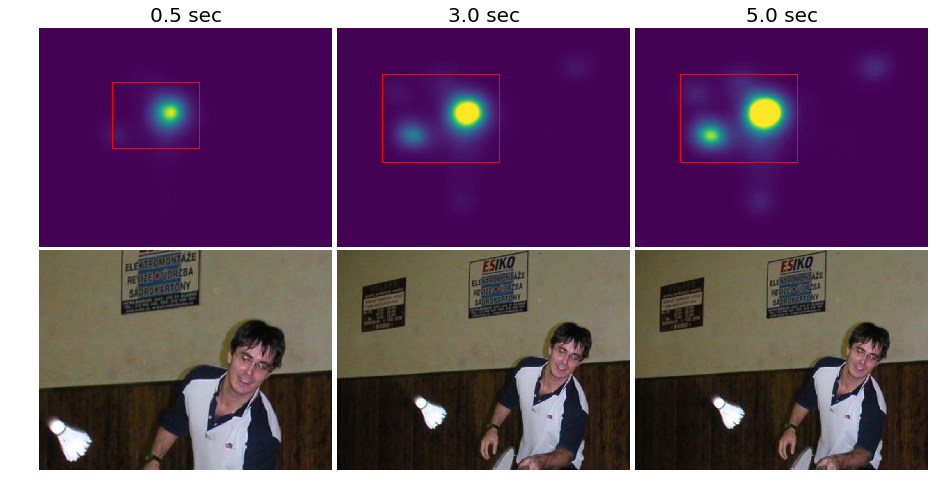

CAT2000Actions_013


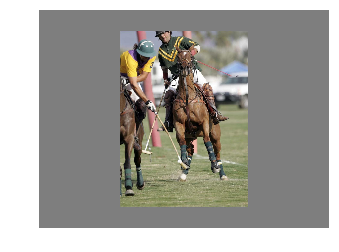

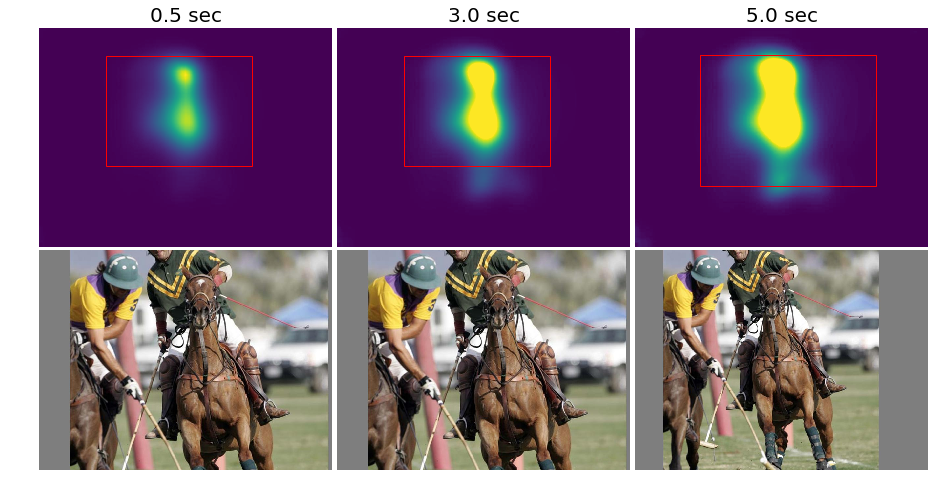

CAT2000Actions_015


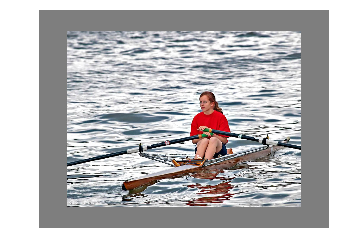

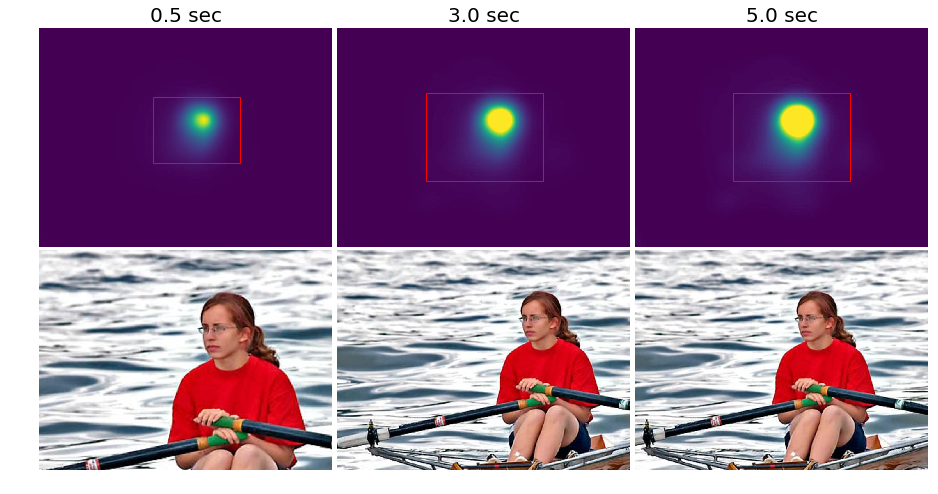

CAT2000Actions_017


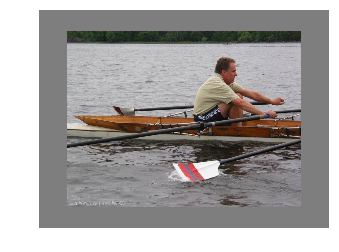

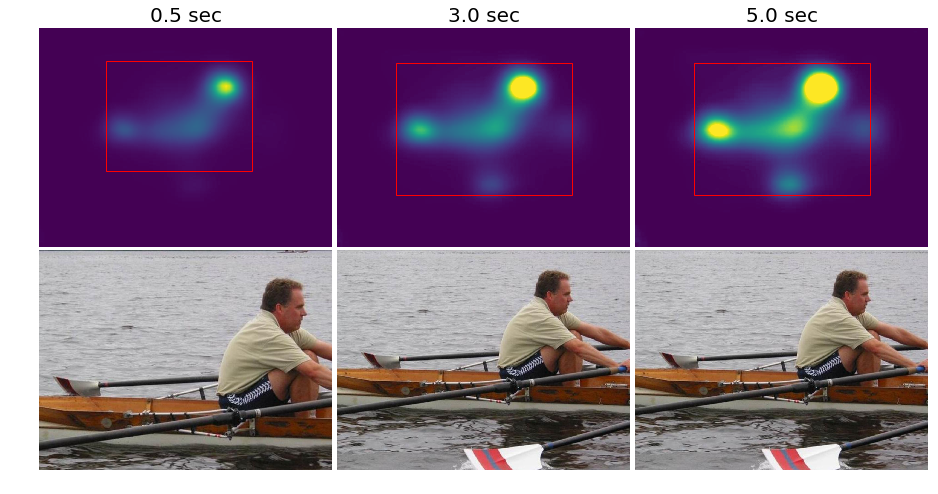

CAT2000Actions_019


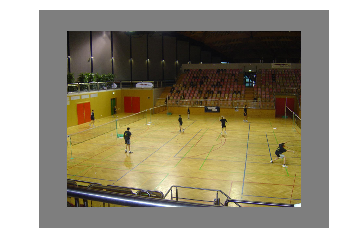

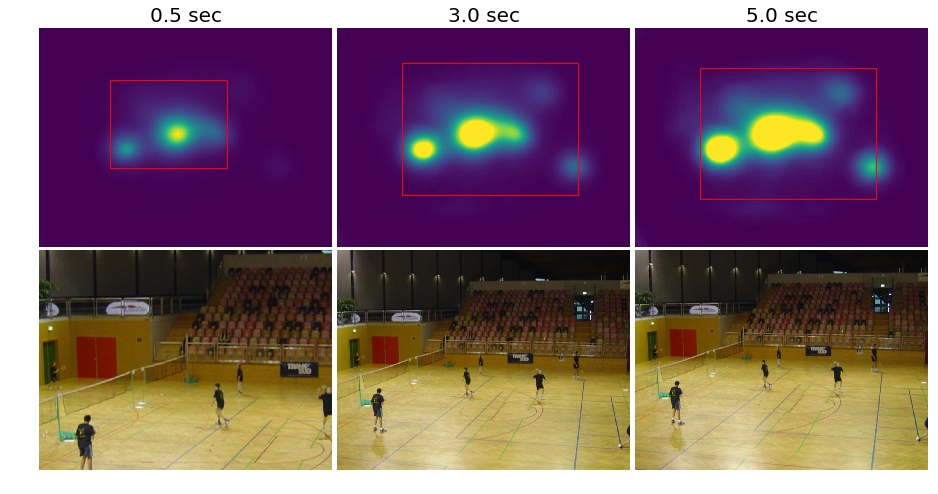

In [16]:
# display results
for imname in imnames:
    ori_imname = imname + '.{}'.format(ori_filetype)
    sal_imname = imname + '.{}'.format(sal_filetype)
    # extract raw images
    ori_impath = os.path.join(codecharts_images_path, ori_imname)
    # extract saliency predictions at each time point
    sal_impaths = [os.path.join(saliency_path, sal_imname) for saliency_path in saliency_paths]
    
    ori_im = cv2.imread(ori_impath)
    sal_ims = [cv2.imread(sal_impath, 0) for sal_impath in sal_impaths]
    if (all([sal_im[0].shape == ori_im.shape[0:2] for sal_im in sal_ims])):
        tmp_files = sal_impaths
        write_success = True
    else:
        sal_ims = [cv2.resize(sal_im, ori_im.shape[1::-1]) for sal_im in sal_ims]
        tmp_files = [os.path.join(tmp_folder, "{}_".format(time)+sal_imname) for time in time_pts]
        # need to save the images so that heatmap size is the same as raw images
        write_success = [cv2.imwrite(tmp_file, sal_im) for tmp_file, sal_im in zip(tmp_files, sal_ims)]
    if (all(write_success)):
        plt.imshow(cv2.cvtColor(ori_im,cv2.COLOR_BGR2RGB))
        plt.axis('off')
        fig, axes = plt.subplots(2,3, figsize=(12,6))
        axes = axes.flatten()
        for ax in axes:
            ax.axis('off')
        heatmap_list = []
        current_heatmap = np.zeros(ori_im.shape[:2], dtype=float)
        for i, (time, tmp_file) in enumerate(zip(time_pts, tmp_files)):
            current_heatmap += cv2.imread(tmp_file, 0)
            cv2.imwrite(tmp_heatmap_file, current_heatmap)
            best_x, best_y, best_w, best_h = baseline.saliency_crop(ori_impath,current_heatmap_file,maxDiff=False)
            axes[i].set_title("{} sec".format(time_pts[i]/1000), fontsize=20)
            rect = Rectangle((best_x, best_y),best_w, best_h, color='r', fill=False)
            axes[i].imshow(current_heatmap,vmin=0,vmax=254)
            axes[i].add_patch(rect)
            axes[i+3].imshow(cv2.cvtColor(ori_im,cv2.COLOR_BGR2RGB)[best_y:best_y+best_h,best_x:best_x+best_w,:])
        plt.tight_layout(pad=-3)
        print(imname)
        plt.show()
    else:
        print(" failed".format(imname))